<a href="https://colab.research.google.com/github/edenau/Machine-Learning-Climate-Parameterization/blob/master/work/NN/colab/RF-1hrlater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Virtual environment
#! export PATH="/scratch/$USER/miniconda/base/bin:$PATH"
#! source activate venv

import time
# MATLAB like tic toc
def TicTocGenerator():
    ti = 0
    tf = time.time()
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti
TicToc = TicTocGenerator() # create an instance of the TicTocGen generator
def toc(tempBool=True):
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: {:.1f} seconds.".format(tempTimeInterval) )
def tic():
    toc(False)
tic()

In [84]:
# Import pkg
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sb
from math import floor, ceil
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import tensorflow as tf
print('All packages imported.')
toc()

All packages imported.
Elapsed time: 167.1 seconds.


In [47]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/gdrive')

# Check data list
!ls "/content/gdrive/My Drive/Colab Notebooks/data/"
!ls '/tmp'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ARM_1hrlater.csv  ARM_6hrcumul.csv  ARM_no_dropna.cdf  ARM_strict_dropna.csv
drivefs_ipc.0  drivefs_ipc.0_shell


In [140]:
# Read data
DATADIR = '/content/gdrive/My Drive/Colab Notebooks/data'
#DATADIR = '../data/forNN'
#f = DATADIR + '/ARM_6hrcumul.csv'
f = DATADIR + '/ARM_1hrlater.csv'
df = pd.read_csv(f,index_col=0) # the first column in .csv is index

# Double check NaN does not exist
print('There are {} NaN in the data.'.format(df.isnull().sum().sum()))
df = shuffle(df) # shuffle
df.shape

There are 0 NaN in the data.


(4847, 152)

In [141]:
# Generate inputs and labels
#input = df.drop(columns='prec_sfc_6hrcumul')
input = df.drop(columns='prec_sfc_1hrlater')
#raw_label = df['prec_sfc_6hrcumul']
raw_label = df['prec_sfc_1hrlater']

## >0.31 mm in 6-hour period is counted as rainy
label = (raw_label.values > 0) *1 # ensure it is in int type # or set 0.1
print('Rainy period ratio= {:.4f}'.format(label.sum()/label.size))

Rainy period ratio= 0.4869


In [142]:
# Split data, deep copy to prevent contaminating raw data with standardization
train_size = 0.6
train_cnt = floor(input.shape[0] * train_size)

x_train = input.iloc[0:train_cnt].copy().values
y_train = label[0:train_cnt].copy()#.reshape([-1,1])
x_test = input.iloc[train_cnt:].copy().values
y_test = label[train_cnt:].copy().reshape([-1,1])

# No need to normalize data for random forests
'''
# Normalize data
INPUT_PRE_NORM = tf.placeholder("float", [None, None], name='pre_norm')
mean, variance = tf.nn.moments(INPUT_PRE_NORM, [0], name='moments') # batch normalization
std = tf.sqrt(variance)

NORM_MEAN = tf.placeholder("float", [None])
NORM_STD = tf.placeholder("float", [None])
normalized = (INPUT_PRE_NORM - NORM_MEAN) / NORM_STD
with tf.Session() as sess:
  # Normalize everything using mean/std of training data
  _mean, _std = sess.run([mean, std], feed_dict = {INPUT_PRE_NORM: x_train})
  x_train = sess.run(normalized, feed_dict = {INPUT_PRE_NORM: x_train,
                                              NORM_MEAN: _mean,
                                              NORM_STD: _std})
  # Double check _mean_0, _std_1 are all zeros and ones
  #_mean_0, _std_1 = sess.run([mean, std], feed_dict = {INPUT_PRE_NORM: x_train})
  #print(_mean_0, _std_1)

  x_test = sess.run(normalized, feed_dict = {INPUT_PRE_NORM: x_test,
                                             NORM_MEAN: _mean,
                                             NORM_STD: _std})

  # No normalization for labels
'''
toc()

Elapsed time: 203.6 seconds.


In [143]:
# Build Random Forest

for num_tree in [1000]:
  clf = RandomForestClassifier(n_estimators=num_tree)
  clf = clf.fit(x_train, y_train)

  # Predict and calculate accuracy
  pred = clf.predict(x_test).reshape([-1,1])
  with tf.Session() as sess:
    PRED = tf.placeholder(tf.int32, [None,1])
    LABEL = tf.placeholder(tf.int32, [None,1])
    same = tf.equal(PRED, LABEL)
    accuracy = tf.reduce_mean(tf.cast(same, tf.float32))
  
    _accuracy = sess.run(accuracy, feed_dict={PRED: pred, LABEL: y_test})

  print('#tree= {}, test accuracy= {:.4f}'.format(num_tree, _accuracy))

toc()

#tree= 1000, test accuracy= 0.8571
Elapsed time: 39.0 seconds.


Predicted number of rainy hours= 848, total hours= 1939


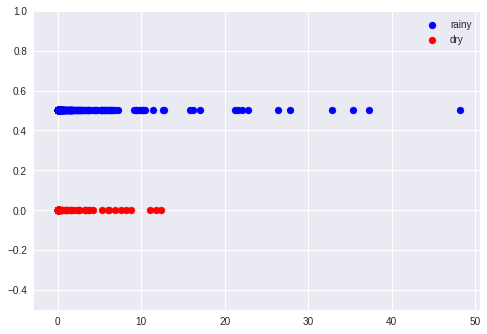

In [144]:
# Plot
test_raw_label = raw_label[train_cnt:].values
rainy = pred == 1
print('Predicted number of rainy hours= {}, total hours= {}'.format(rainy.sum(), rainy.size))
plt.figure()
plt.scatter(test_raw_label[rainy[:,0]], np.zeros(test_raw_label[rainy[:,0]].size) + .5, c='blue', label='rainy')
plt.scatter(test_raw_label[~rainy[:,0]], np.zeros(test_raw_label[~rainy[:,0]].size), c='red', label='dry')
axes = plt.gca()
#axes.set_xlim([0,20])
axes.set_ylim([-.5,1])
axes.legend()

plt.show()


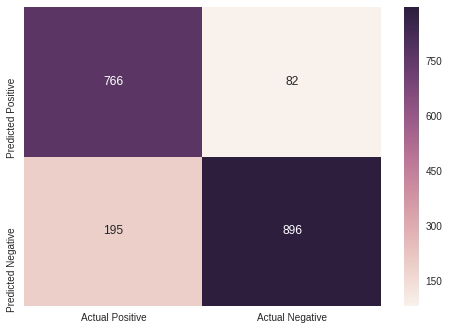

In [145]:
# Confusion matrix
conf = [[np.logical_and(pred, y_test).sum(), np.logical_and(pred, np.logical_not(y_test)).sum()],
        [np.logical_and(np.logical_not(pred), y_test).sum(), np.logical_and(np.logical_not(pred), np.logical_not(y_test)).sum()]] # [TP,FP],[FN,TN]
df_conf = pd.DataFrame(conf, index = [i for i in ['Predicted Positive','Predicted Negative']], columns = [i for i in ['Actual Positive','Actual Negative']])

plt.figure()
sb.heatmap(df_conf, annot=True, fmt='.0f')
plt.show()

(4847, 1)

In [155]:
# Append predicted class on df
pred_all = clf.predict(input.values).reshape([-1,1])
df_nn = df.copy()
try: # enable re-run
  df_nn.insert(loc=0, column='pred_class', value=pred_all)
except:
  print('Column pred_class has already inserted.')

df_nn

,pred_class,hour_cos,hour_sin,prec_sfc_1hrlater,prec_sfc,T_p1000,T_p975,T_p950,T_p925,T_p900,...,v_p325,v_p300,v_p275,v_p250,v_p225,v_p200,v_p175,v_p150,v_p125,v_p100
4822,0,0.965926,-2.588190e-01,0.000000,0.000000,301.536194,299.602814,297.543915,295.783112,294.198425,...,-0.736046,-0.436770,0.551084,-1.568495,0.330352,-1.459406,-5.015362,2.486673,-0.348639,-0.261705
2560,1,0.965926,-2.588190e-01,0.000033,0.000000,300.622223,299.426453,297.702637,296.044739,294.934204,...,-10.826406,-8.269476,-5.344326,-5.176578,-2.293838,0.978394,2.745706,7.512728,10.840754,-6.324321
607,1,-0.965926,2.588190e-01,0.060000,0.060000,299.190887,297.073792,295.322723,295.630005,293.891388,...,1.469207,-2.199076,-3.734375,-3.466331,-4.540835,-5.696366,-1.443994,0.354838,0.587572,-5.247960
4020,0,0.965926,-2.588190e-01,0.000000,0.000000,301.464996,298.979523,296.938629,295.582367,294.679138,...,-3.750479,-3.416218,-3.406285,-3.471120,-4.232746,-5.387029,-5.313039,-7.564689,-4.973135,-0.425526
151,1,0.866025,-5.000000e-01,0.556667,0.071167,299.549988,297.695007,295.655243,294.140900,293.069031,...,9.280911,10.172801,9.119032,7.304665,9.563134,12.922034,12.908717,13.065999,8.076972,-2.696848
2751,0,-0.965926,2.588190e-01,0.000000,0.000000,300.232361,299.184784,297.484772,295.971741,294.600006,...,1.028868,1.502950,1.321547,0.439833,2.531309,2.267687,-0.734401,-8.772366,-2.151905,-3.576836
2012,1,0.965926,-2.588190e-01,0.104852,0.800117,299.220001,298.284790,297.546143,296.311523,294.545654,...,-1.075089,-0.097172,-1.374330,-4.104781,-4.328582,-4.488903,-2.702836,-0.426713,-4.351744,-10.800318
4559,1,0.965926,-2.588190e-01,0.307689,0.290541,301.752777,299.533325,297.345001,295.933990,295.250000,...,-0.473068,1.795856,1.275860,-0.168661,-0.642684,-2.065826,4.655173,7.612150,-2.601419,3.357258
2700,0,-0.965926,2.588190e-01,0.000000,0.000000,301.031250,299.660522,298.104553,296.487030,295.153320,...,1.098644,1.020521,1.022150,-2.255609,-4.996295,-3.878857,-1.840269,0.440368,3.596848,4.158068
3008,0,1.000000,0.000000e+00,0.000000,0.000000,302.493500,299.945709,297.921295,296.063629,294.170898,...,-1.126933,-2.879350,-5.471157,-6.980046,-4.756661,-4.296210,-5.396024,-7.423729,-5.666748,0.638203


In [0]:
# Export it into .csv
f = "/content/gdrive/My Drive/Colab Notebooks/data/ARM_1hrlater_RFclassified.csv"
df_nn.to_csv(f)